In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib
import seaborn as sns

sys.path.append(str(Path(os.getcwd()).parent))

In [4]:
from src import extract_tree_stats, curve_inference, estimators, loader

# Test estimators

In [5]:
filenames = glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/another_desai_20230626/seed=*/output.trees")

In [181]:
ts = loader.load_tree_sequence_from_slim(
    filename = filenames[0],
    n_samples_per_time = [1000],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 1e-2,
    random_seed = 42,
)

In [184]:
estimators.composite_likelihood(ts)

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 240280.09527603563
                          x: [ 1.255e-02  2.461e-02  2.378e-02]
                        nit: 100
      minimization_failures: 0
                       nfev: 16413
 lowest_optimization_result:       message: Optimization terminated successfully.
                                   success: True
                                    status: 0
                                       fun: 240280.09527603563
                                         x: [ 1.255e-02  2.461e-02
                                              2.378e-02]
                                       nit: 69
                                      nfev: 124
                             final_simplex: (array([[ 1.255e-02,
                                                     2.461e-02,
                                                     2.378e-02],
  

# Now test systematically

## The effect of sample size, with all samples at time T=0

In [267]:
def optimize_me(filename, sample_size):
    ts = loader.load_tree_sequence_from_slim(
        filename = filename,
        n_samples_per_time = [sample_size],
        sample_times = [0],
        neutral_mutation_rate_per_genome = 1e-2,
        random_seed = 42,
    )

    return estimators.better_composite_likelihood(ts, mutation_times_known=False).x

res = {}
for sample_size in [100, 1000, 10000]:
    print(sample_size)
    res[sample_size] = joblib.Parallel(n_jobs=-1, verbose=50)(
        joblib.delayed(optimize_me)(filename, sample_size) \
            for filename in filenames
        )

100
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   3 out of 100 | elapsed:    6.3s remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   6 out of 100 | elapsed:    6.8s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   9 out of 100 | elapsed:    7.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of 100 | elapsed:    7.1s remaining:   52.2s
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    7.2s remaining:   40.6s
[Parallel(n_jobs=-1)]: Done  18 out of 100 | elapsed:    7.3s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:    7.4s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed:    7.4s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  27 out of 100 | elapsed:    7.6s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  30 out of 100 | elapsed:    7.6s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  33 out of 100 | el

In [268]:
rows = []
for k, v in res.items():
    for i, (est_Un, est_Ud, est_s) in enumerate(v):
        rows.append([k, i, est_Un, est_Ud, est_s])

res_df = pd.DataFrame(rows, columns=["sample_size", "repeat", "est_Un", "est_Ud", "est_s"])

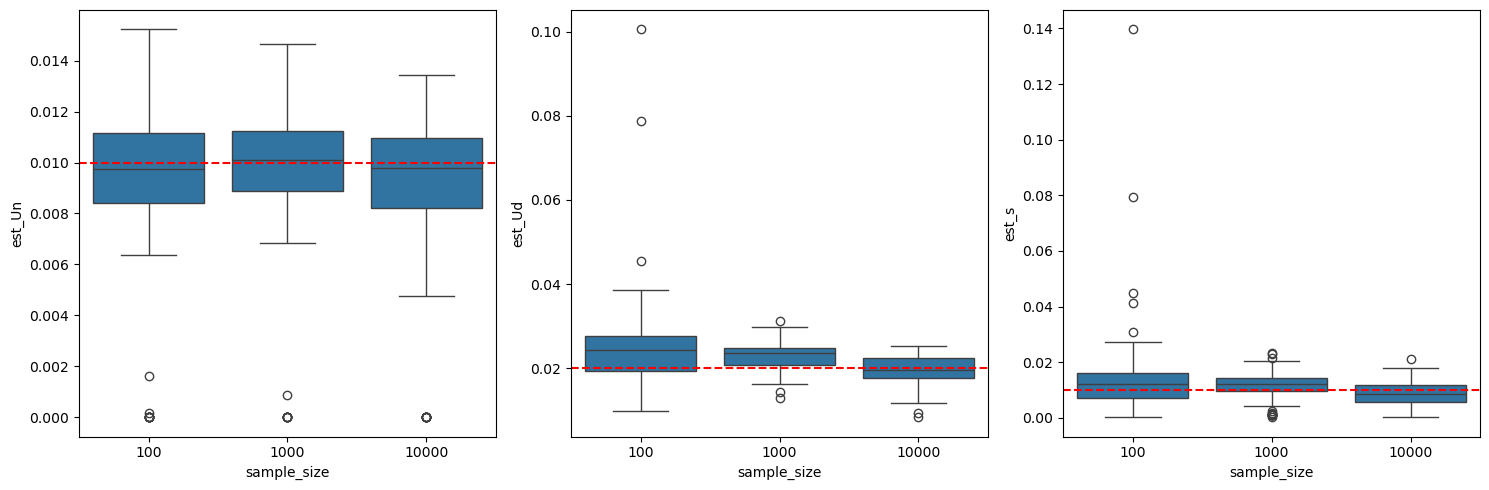

In [269]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(res_df, x="sample_size", y="est_Un", ax=axs[0]);
axs[0].axhline(0.01, color="red", ls="--");
#axs[0].set_ylim(0, 0.04);

sns.boxplot(res_df, x="sample_size", y="est_Ud", ax=axs[1]);
axs[1].axhline(0.02, color="red", ls="--");
#axs[1].set_ylim(0, 0.04);

sns.boxplot(res_df, x="sample_size", y="est_s", ax=axs[2]);
axs[2].axhline(0.01, color="red", ls="--");
#axs[2].set_ylim(0, 0.04);

plt.tight_layout()

In [192]:
ts = loader.load_tree_sequence_from_slim(
    filename = filenames[23],
    n_samples_per_time = [100],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 1e-2,
    random_seed = 42,
)

mut_times_cnt, no_mut_times_cnt = estimators.composite_likelihood(ts, return_counts_only=True)

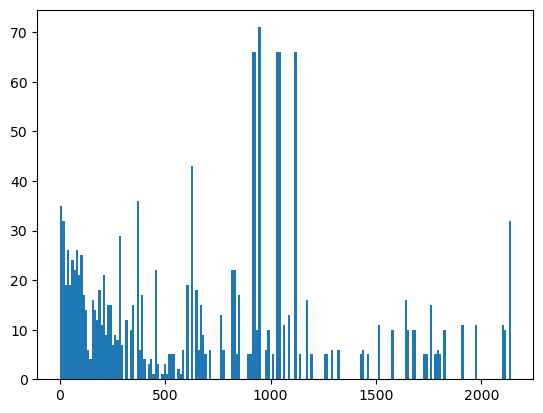

In [194]:
plt.hist(
    list(mut_times_cnt.keys()),
    weights=list(mut_times_cnt.values()),
    bins=200,
);

## Various neutral mutation rates

In [270]:
def optimize_me(filename, neutral_mutation_rate_per_genome):
    ts = loader.load_tree_sequence_from_slim(
        filename = filename,
        n_samples_per_time = [1000],
        sample_times = [0],
        neutral_mutation_rate_per_genome = neutral_mutation_rate_per_genome,
        random_seed = 42,
    )

    return estimators.composite_likelihood(ts, mutation_times_known=False).x

res = {}
for neutral_mutation_rate_per_genome in [0, 1e-3, 1e-2, 1e-1]:
    print(neutral_mutation_rate_per_genome)
    res[neutral_mutation_rate_per_genome] = joblib.Parallel(n_jobs=-1, verbose=20)(
        joblib.delayed(optimize_me)(filename, neutral_mutation_rate_per_genome) \
            for filename in filenames
        )

0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of 100 | elapsed:    2.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of 100 | elapsed:    2.4s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    2.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:    2.4s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  27 out of 100 | elapsed:    2.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  33 out of 100 | elapsed:    2.5s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  39 out of 100 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  45 out of 100 | elapsed:    2.7s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  51 out of 100 | elapsed:    2.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  57 out of 100 | elapsed:    2.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  63 out of 100 | elapse

0.001


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 out of 100 | elapsed:    2.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of 100 | elapsed:    2.8s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    2.8s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:    2.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  27 out of 100 | elapsed:    3.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  33 out of 100 | elapsed:    3.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  39 out of 100 | elapsed:    3.3s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  45 out of 100 | elapsed:    3.4s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  51 out of 100 | elapsed:    3.4s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  57 out of 100 | elapsed:    3.6s

0.01


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of 100 | elapsed:    4.1s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of 100 | elapsed:    4.3s remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:    4.4s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:    4.5s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  27 out of 100 | elapsed:    4.6s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  33 out of 100 | elapsed:    4.7s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  39 out of 100 | elapsed:    4.8s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  45 out of 100 | elapsed:    4.8s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  51 out of 100 | elapsed:    4.9s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  57 out of 100 | elapsed:    5.1s

0.1


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   3 out of 100 | elapsed:   13.5s remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   9 out of 100 | elapsed:   14.6s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  15 out of 100 | elapsed:   15.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:   15.5s remaining:   58.3s
[Parallel(n_jobs=-1)]: Done  27 out of 100 | elapsed:   15.9s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done  33 out of 100 | elapsed:   16.4s remaining:   33.4s
[Parallel(n_jobs=-1)]: Done  39 out of 100 | elapsed:   16.6s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done  45 out of 100 | elapsed:   16.9s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  51 out of 100 | elapsed:   17.5s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  57 out of 100 | elapsed:   17.9s

In [271]:
rows = []
for k, v in res.items():
    for i, (est_Un, est_Ud, est_s) in enumerate(v):
        rows.append([k, i, est_Un, est_Ud, est_s])

res_df = pd.DataFrame(rows, columns=["Un", "repeat", "est_Un", "est_Ud", "est_s"])

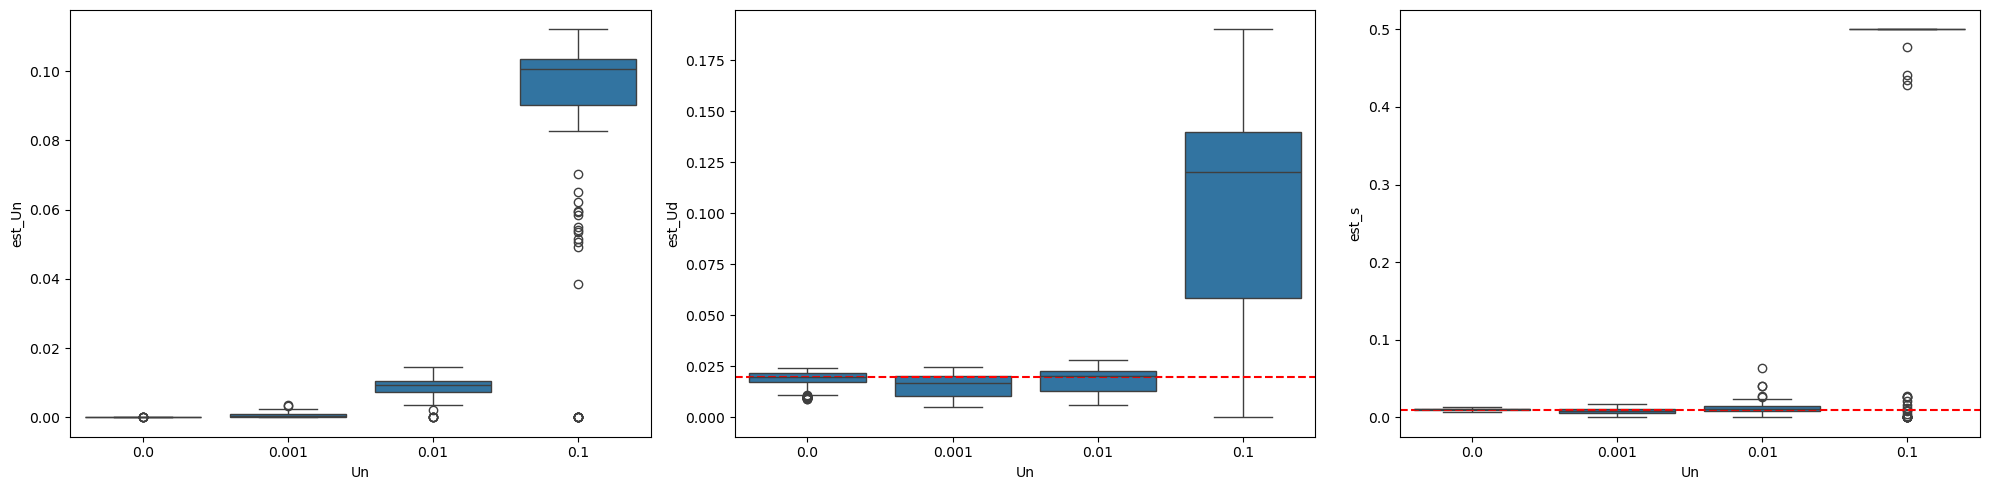

In [272]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(res_df, x="Un", y="est_Un", ax=axs[0]);
#axs[0].axhline(0.01, color="red", ls="--");

sns.boxplot(res_df, x="Un", y="est_Ud", ax=axs[1]);
axs[1].axhline(0.02, color="red", ls="--");
#axs[1].set_ylim(0, 0.04);

sns.boxplot(res_df, x="Un", y="est_s", ax=axs[2]);
axs[2].axhline(0.01, color="red", ls="--");
#axs[2].set_ylim(0, 0.04);

plt.tight_layout()

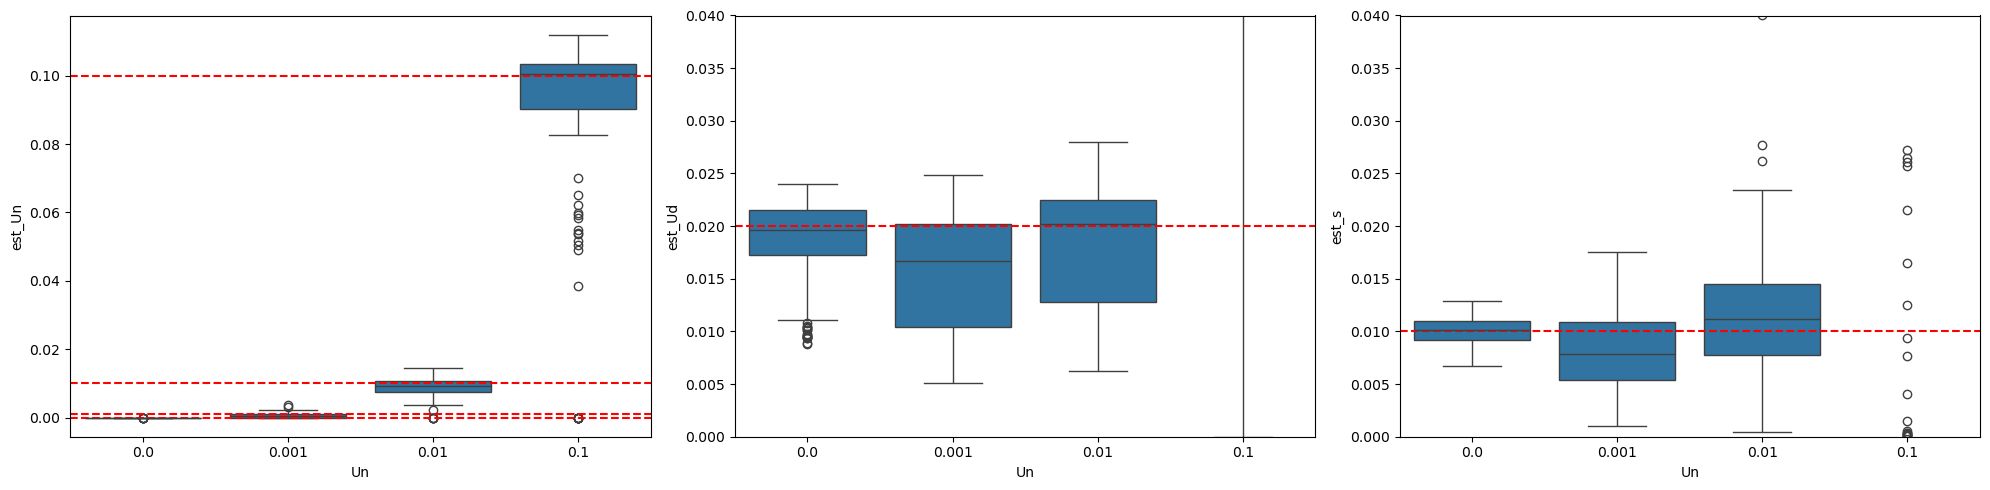

In [273]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(res_df, x="Un", y="est_Un", ax=axs[0]);
axs[0].axhline(0, color="red", ls="--");
axs[0].axhline(0.001, color="red", ls="--");
axs[0].axhline(0.01, color="red", ls="--");
axs[0].axhline(0.1, color="red", ls="--");

sns.boxplot(res_df, x="Un", y="est_Ud", ax=axs[1]);
axs[1].axhline(0.02, color="red", ls="--");
axs[1].set_ylim(0, 0.04);

sns.boxplot(res_df, x="Un", y="est_s", ax=axs[2]);
axs[2].axhline(0.01, color="red", ls="--");
axs[2].set_ylim(0, 0.04);

plt.tight_layout()

In [116]:
ts = loader.load_tree_sequence_from_slim(
    filename = filenames[0],
    n_samples_per_time = [1000],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 0.1,
    random_seed = 42,
)

mut_times_cnt, no_mut_times_cnt = estimators.composite_likelihood(ts, return_counts_only=True)

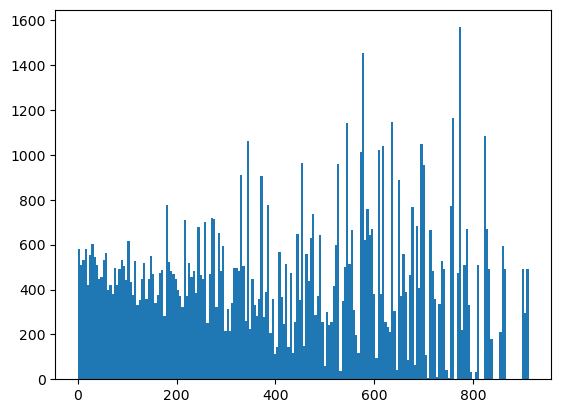

In [118]:
plt.hist(
    list(mut_times_cnt.keys()),
    weights=list(mut_times_cnt.values()),
    bins=200,
);

# Better estimator 

In [264]:
ts = loader.load_tree_sequence_from_slim(
    filename = filenames[0],
    n_samples_per_time = [1000],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 1e-2,
    random_seed = 42,
)

branch_interval_counts, whole_interval_counts = estimators.better_composite_likelihood(ts, mutation_times_known=False, return_counts_only=True)
res = estimators.better_composite_likelihood(ts, mutation_times_known=False, return_counts_only=False)
print(res)

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 180826.11446597904
                          x: [ 1.264e-02  2.607e-02  2.348e-02]
                        nit: 100
      minimization_failures: 0
                       nfev: 15460
 lowest_optimization_result:       message: Optimization terminated successfully.
                                   success: True
                                    status: 0
                                       fun: 180826.11446597904
                                         x: [ 1.264e-02  2.607e-02
                                              2.348e-02]
                                       nit: 63
                                      nfev: 121
                             final_simplex: (array([[ 1.264e-02,
                                                     2.607e-02,
                                                     2.348e-02],
  

In [266]:
branch_interval_counts

defaultdict(int,
            {(466.0, 857.0): 1253,
             (282.0, 466.0): 284,
             (5.0, 282.0): 4,
             (64.0, 232.0): 6,
             (0.0, 64.0): 15,
             (0.0, 125.0): 9,
             (45.0, 113.0): 6,
             (0.0, 45.0): 7,
             (59.0, 98.0): 12,
             (38.0, 59.0): 5,
             (0.0, 54.0): 13,
             (3.0, 33.0): 2,
             (15.0, 33.0): 4,
             (0.0, 15.0): 8,
             (5.0, 15.0): 5,
             (77.0, 98.0): 8,
             (27.0, 77.0): 5,
             (9.0, 27.0): 3,
             (45.0, 77.0): 9,
             (1.0, 45.0): 4,
             (200.0, 230.0): 46,
             (75.0, 200.0): 72,
             (36.0, 75.0): 3,
             (61.0, 75.0): 15,
             (0.0, 9.0): 12,
             (0.0, 27.0): 11,
             (0.0, 23.0): 11,
             (0.0, 21.0): 8,
             (46.0, 61.0): 5,
             (23.0, 46.0): 6,
             (47.0, 177.0): 25,
             (0.0, 47.0): 1,
            

In [260]:
T.parent(node)

1985